<a href="https://colab.research.google.com/github/sg-peytrignet/algeria24-training/blob/main/0_eda_standardization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICT infrastructure data exploratory analysis

Welcome to this hands-on session where we'll learn how to analyze infrastructure data using Python. We'll be working with data from Algeria to understand how to obtain, process and prepare different layers of infrastructure data. This tutorial will teach you how to handle geographic data, create visualizations for exploratory data analysis, and standardize infrastructure data for analysis.

## Setting up our environment

We start by importing the Python libraries we'll need for our analysis:
- geopandas and shapely: For handling geographic data and operations
- pandas: For data manipulation and analysis
- matplotlib and contextily: For creating visualizations and adding map backgrounds
- osmnx: For accessing OpenStreetMap data
- Other utility libraries for various tasks like generating UUIDs and handling country codes

In [1]:
!pip install osmnx contextily summarytools pycountry

In [2]:
# Standard library imports
import os
import math

# Data manipulation and analysis
import pandas as pd
import numpy as np
import uuid

# Geospatial libraries
import geopandas as gpd
import osmnx as ox
from shapely.ops import unary_union
import pycountry

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import contextily as cx
import folium

# Interactive tools and display
import ipywidgets as widgets
from IPython.display import display, HTML
from summarytools import dfSummary

We set `fetch_data = False` to use pre-downloaded data instead of fetching it live during the tutorial.

In [3]:
fetch_data = False

## Get country boundaries

Before analyzing infrastructure within Algeria, we need to define the country's boundaries. We:
1. Load a GeoJSON file containing global UN-recognized country boundaries using geopandas
2. Filter to get just Algeria's boundary
3. Calculate the country's bounding box and UTM projection zone for later use
4. Get Algeria's ISO3 country code for standardization

This boundary data will be crucial for clipping our infrastructure data and ensuring we're analyzing points within Algeria's borders.

In [4]:
un_boundaries = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/country_boundary_data/boundaries.geojson")
algeria = un_boundaries[un_boundaries.romnam == "Algeria"]

<Axes: >

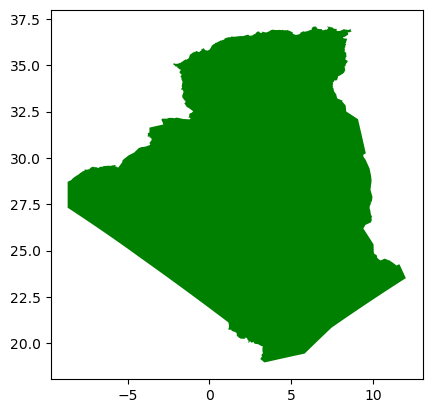

In [5]:
algeria.plot(color="green")

In [6]:
algeria_boundary = algeria.total_bounds
algeria_utm = algeria.estimate_utm_crs()
algeria_latitude = algeria.centroid.y.squeeze()

/var/folders/ww/ybnnslt14m96q4bwh3jfbd5h0000gn/T/ipykernel_97867/4143853990.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  algeria_latitude = algeria.centroid.y.squeeze()


In [7]:
def get_iso3_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_3
    except AttributeError:
        return None

In [8]:
algeria_iso3 = get_iso3_country_code("Algeria")
print(f"The ISO-3 code for Algeria is {algeria_iso3}")

The ISO-3 code for Algeria is DZA


## Get point of interest (POI) data

<img src="https://wiki.openstreetmap.org/w/images/c/c8/Public-images-osm_logo.png" alt="OpenStreetMap logo" width="20%">

[OpenStreetMap](https://www.openstreetmap.org/) (OSM) is an open-source, community-driven geospatial data project that provides free and editable geographic information at a global scale. Established in 2004, OSM functions as a vast, collaborative mapping database where users contribute data on roads, buildings, land use, natural features, and more, creating a detailed digital representation of the world's infrastructure. Its open data licensing and API access make it highly valuable for applications in GIS analysis, urban planning, transportation modeling, and disaster response.

Thanks to this resoruce, we load data about schools in Algeria. The code:
1. Either fetches school data from OpenStreetMap using the osmnx API and the `amenity=school` tag (if fetch_data=True) or loads pre-downloaded data
2. Filters the data to keep only relevant columns (ID, amenity type, city, education level, etc.)
3. Processes the geographical coordinates for each school

This data will help us understand the distribution of educational facilities across the country and identify areas that might be underserved.

In [9]:
if fetch_data:
    place = "Algeria"
    tags = {"amenity": "school"}
    algeria_schools_gdf = ox.features_from_place(place, tags)
else:
    algeria_schools_gdf = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-schools.geojson")

In [10]:
algeria_schools_gdf = algeria_schools_gdf[["osmid","amenity","element_type","addr:city","isced:level","operator", "geometry"]]

## Get Ookla speed test data

<img src="https://i.ibb.co/wcB1JHC/Screenshot-2024-10-25-at-21-24-24.png" alt="Ookla Open Data" width="75%">

[Ookla](https://www.ookla.com/ookla-for-good/open-data), known for its Speedtest platform, offers open data on internet speeds, latency, and network quality worldwide. Their datasets, like the Speedtest Global Index, help researchers analyze internet performance and infer knowledge about infrastructure gaps.

Here, we process their internet speed test data. For both mobile and fixed broadband:
1. We load data from Ookla's public dataset hosted as parquet files on Amazon Web Services (or pre-downloaded files)
2. Filter the data to Algeria's geographical bounds obtained earlier
3. Fetch key metrics like average download speed (avg_d_kbps) and latency (avg_lat_ms)
4. For mobile data, we can also create coverage polygons by buffering around test points. The Ookla data is available as tiles which are approximately 610.8 meters by 610.8 meters at the equator.
Fore more information about processing open data from Ookla, visit their [GitHub](https://github.com/teamookla/ookla-open-data) page.

In [11]:
def get_perf_tiles_parquet_url(service: str, year: int, quarter: int) -> str:
    quarter_start = f"{year}-{(((quarter - 1) * 3) + 1):02}-01"
    url = f"s3://ookla-open-data/parquet/performance/type={service}/year={year}/quarter={quarter}/{quarter_start}_performance_{service}_tiles.parquet"
    return url

### Mobile

In [12]:
if fetch_data:
    mobile_perf_tiles_url = get_perf_tiles_parquet_url("mobile", 2024, 2)
    bbox_filters = [('tile_y', '<=', algeria_boundary[3]), ('tile_y', '>=', algeria_boundary[1]),
                ('tile_x', '<=', algeria_boundary[2]), ('tile_x', '>=', algeria_boundary[0])]
    mobile_tiles_df = pd.read_parquet(mobile_perf_tiles_url,
                           filters=bbox_filters,
                           columns=['tile_x', 'tile_y', 'tests', 'avg_d_kbps', 'avg_lat_ms'],
                           storage_options={"s3": {"anon": True}}
                           )
else:
    mobile_tiles_df = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-ookla-mobile-tiles.csv",index_col=0)

In [13]:
mobile_tiles_gdf = gpd.GeoDataFrame(mobile_tiles_df, geometry=gpd.points_from_xy(mobile_tiles_df.tile_x, mobile_tiles_df.tile_y), crs="EPSG:4326").drop(columns=["tile_x", "tile_y"])

#### Generate mobile coverage area

We infer mobile coverage areas from Ookla's internet speed test data. We assume that areas where there have been succesful mobile speed tests are areas that have cellular coverage, and vice versa. We do not have information, however, on which cellular technology it refers to (3G, 4G, 5G).

In [14]:
tile_size_at_latitude=610.8*np.cos(math.radians(algeria_latitude))
buffers = mobile_tiles_gdf.to_crs(algeria_utm).buffer(tile_size_at_latitude).to_crs("EPSG:4326")
single_polygon = unary_union(buffers)
algeria_mobile_coverage_gdf = gpd.GeoDataFrame(geometry=[single_polygon], crs="EPSG:4326")

### Fixed

In [15]:
if fetch_data:
    fixed_perf_tiles_url = get_perf_tiles_parquet_url("fixed", 2024, 2)
    fixed_tiles_df = pd.read_parquet(fixed_perf_tiles_url,
                           filters=bbox_filters,
                           columns=['tile_x', 'tile_y', 'tests', 'avg_d_kbps', 'avg_lat_ms'],
                           storage_options={"s3": {"anon": True}}
                           )
else:
    fixed_tiles_df = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-ookla-fixed-tiles.csv")

## Get cell site data

<img src="https://wiki.opencellid.org/images/d/de/OpenCellID_banner_main_page2.png" alt="Ookla Open Data" width="50%">

[OpenCellID](https://wiki.opencellid.org/wiki/What_is_OpenCellID) is the world's largest collaborative community project that collects GPS positions of cell towers, used free of charge, for a multitude of commercial and private purposes. Notably, they publish data on cell site coordinates. In order to download their data, register at their page and obtain a free API acces token. Using this token, you will be able to download [datasets](https://opencellid.org/downloads.php) for each country.

The code below:
1. Loads a CSV file containing cell site coordinates obtained from OpenCellID.
2. Converts it to a GeoDataFrame for spatial analysis

In [16]:
algeria_cell_sites = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-cell-sites.csv")

In [17]:
algeria_cell_sites_gdf = gpd.GeoDataFrame(algeria_cell_sites, geometry=gpd.points_from_xy(algeria_cell_sites.lon, algeria_cell_sites.lat), crs="EPSG:4326").drop(columns=["lon", "lat"])

## Get transmission node data

<img src="https://www.itu.int/en/ITU-D/Technology/PublishingImages/bbmaps-snpashot.png" alt="Ookla Open Data" width="50%">

We obtain data on fiber transmission nodes from the ITU's own [Connectivity Infrastructure Maps](https://bbmaps.itu.int/bbmaps/) platform. Access to the raw data is restricted to registered users, so we fetch a version of the data uploaded unto our servers. These transmission nodes in this dataset represent key internet infrastructure points that form the backbone of Algeria's telecommunications network.

We follow these steps:
1. Read coordinates and attributes of network nodes
2. Convert to a GeoDataFrame for spatial analysis

In [18]:
algeria_nodes = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/algeria-transmission-nodes.csv")

In [19]:
algeria_nodes_gdf = gpd.GeoDataFrame(algeria_nodes, geometry=gpd.points_from_xy(algeria_nodes.lon, algeria_nodes.lat), crs="EPSG:4326").drop(columns=["lon", "lat"])

# Tabular data analysis

Before spatial analysis, we examine our data in tabular form:
1. Use dfSummary to get statistics about each dataset
2. Check for missing values and data quality issues
3. Understand the distribution of different infrastructure types

This step is crucial for ensuring our data is clean and understanding what insights we can extract.

## Point of interest (POI) data

In [20]:
algeria_schools_gdf.head()

,osmid,amenity,element_type,addr:city,isced:level,operator,geometry
0,8563310317,school,node,NaN,NaN,NaN,POINT (3.58047 31.94970)
1,9982148719,school,node,NaN,NaN,NaN,POINT (3.74319 31.97688)
2,1089577820,school,way,NaN,NaN,NaN,"POLYGON ((3.54205 31.95010, 3.54133 31.95043, ..."
3,1089577829,school,way,NaN,NaN,NaN,"POLYGON ((3.52899 31.95300, 3.52894 31.95274, ..."
4,1090862613,school,way,NaN,NaN,NaN,"POLYGON ((3.67784 31.60225, 3.67617 31.60113, ..."


In [21]:
dfSummary(algeria_schools_gdf)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,osmid[int64],Mean (sd) : 1615171916.7 (2253123721.3)min < med < max:4028212.0 < 462852539.0 < 12227517643.0IQR (CV) : 936196757.0 (0.7),"10,647 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACwElEQVR4nO3ZP2/aQBiA8fcgoOOPfBBSZ2PpwFCpQ0aWTl3zYbN2ayT2fACGrihOOAsHF8u4Q6suqUp8Jkpe9PzmvHeH9OjAjqmqSoD3rvXWBwBe4uzQHxhjeiLSDVx/V1XVNnAW+Ou/oRpjepPJ5DqKonHI4mmaPhpjbogVTR26UbtRFI3n8/nWOZfXWdh7bxeLxThJkq6IECoaOfjVLyLinMvjOH4KWL8XMAM8w8MUVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQoWztz7AazHG9ESk22CJXVVV22OdB82cZKjGmN5kMrmOomgcukaapo/GmBtifR9OMlQR6UZRNJ7P51vnXF532HtvF4vFOEmSrogQ6jtwqqGKiIhzLo/j+ClwvHfUw6ARHqagAqFChZP+6m+iLMuOiETGmJBx3hgcGaH+Q5ZlnaIoPk+n03a73a79MMYbg+N71VAb3koiv3+a7APmov1+3wnddLfbnVlr+1dXV/nl5eVjnVnvvb29vY2TJLkwxqQh2xP4c68WatNbqSzLTpZlH4fD4bLVahV1ZouisGVZfsrz/LuIhD71y2AwqP3WoOnnXq/XG2PMNxGpPftHcOhH+CdJ6MUicuDcLwrVe2/r7vrw8DC01vZns5kZjUY/687f39/b5XL5YTab/RiNRpuA2b73frBarXZ1995sNlZEJMsyu1qt+nVmm3zu9Xo9vLu7+zKdTi9CIv+zRmjo9vz8/Ktzbhiyb5OLReTwz6VfOMzqGy9u1NoAAAAASUVORK5CYII="">",0(0.0%)
2,amenity[object],1. school,"10,647 (100.0%)",,0(0.0%)
3,element_type[object],1. way2. node3. relation,"8,011 (75.2%)2,615 (24.6%)21 (0.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnUlEQVR4nO3bQU6DUBSF4fMIqXYCIU26BN0Di3CxLoJFuAdCeANbO8GBs8aJiOfd4P+t4Cb924amJy3LIsChKn0A/o8k6SjpUPoQbOq2LMul9BH36tPp9NI0TVf6EGwn5zyllF6jBVc3TdP1fX9p2/Za+hj83jzPj8MwdOM4HiTFik2S2ra9ns/n99LHYDPH0gd8hwcE2BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGmlr7+A1X6EGwj8mtZ55ynYRg6Bf0PFH4u5zxJupW+4x4bhH0KuUFITPngEvmTLeS7E+uFXVdFXQhhvZDrqsgLIawXeV3F0/HO8KMubIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GATcl0V7R5sI+y6KupCCOuxQYAN6yrY8IAAG2KDTZVSek4p8fSHP1dJepL0UPoQ7B9fo7AhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDDbHBhthgU0l6k/RR+hDsH+sq2PA1CptP50VzOsNf1j4AAAAASUVORK5CYII="">",0(0.0%)
4,addr:city[object],1. nan2. Oum El Bouaghi3. تبسة4. Oran5. Blida6. El Eulma7. Tiaret8. Bouira9. Batna10. Ouled Yaïch11. other,"8,447 (79.3%)70 (0.7%)64 (0.6%)42 (0.4%)41 (0.4%)29 (0.3%)29 (0.3%)26 (0.2%)22 (0.2%)19 (0.2%)1,858 (17.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD9klEQVR4nO3cwW0bVxhG0X8EQrE2QxAEVELSg4pwsS6CRaQHQdAsIkUbZmGnBN0RzHMaeAP4Qo8k5vNyvV4HCnd7PwC3Q2xkxEZGbGTERkZsZMRGRmxkxEZmmZmHmbnf+0FIfFyv17e9Dj+cz+fv67qe9noAOtu2vSzL8mOv4A7rup6enp7ejsfj+x4PQOP19fXb5XI5PT8/38/MPrHNzByPx/fHx8d/9ngAUg97Hu4LAhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTnM/HzXae8H4XN9hX/jw7ZtL5fL5TQ7v+vE59u27WVmPvY63wbhtuy6QVj8l1lU/v/LNnsWz204nM/n7zMze65uuA1367qefk35fG7jU/mdjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOHXCGJmxyEEt8Fr4WQMXsj4y0bG4IWMwQsZP32QERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCHjtXAyBi9kfGYj4xolY11FxrqKjM9sZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIeC2cjHUVGX/ZyBi8kDF4IeOnDzJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZLwWTsbghYzPbGTulmX5a1mWb3s/CL+/u5n5c2b+2PtB+P25RsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzN3M/D0z/+79IPz+DF7IuEbJiI2MdRUZ6yoyrlEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2QMXsi4RsmIjYzBCxmDFzKuUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyLhGyYiNjNjIWFeRsa4i4xolIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNjXUXGuoqMa5SM2MgYvJAxeCHjGiUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI2PwQsbghYxrlMwyMw8zcx+d93G9Xt+is/hiDufz+fu6rqfisG3bXpZl+SG423RY1/X09PT0djwe3z/zoNfX12+Xy+X0/Px8PzNiu0GHmZnj8fj+

## Cell site data

In [22]:
algeria_cell_sites_gdf.head()

,radio,mcc,net,area,cell,unit,range,samples,changeable,created,updated,averageSignal,geometry
0,GSM,603,2,32,5823,0,1723,21,1,1364155159,1728411264,0,POINT (2.97420 36.73800)
1,GSM,603,2,32,10086,0,1308,22,1,1364155159,1719425896,0,POINT (2.97420 36.74470)
2,GSM,603,2,32,10085,0,1000,21,1,1364155159,1722215467,0,POINT (2.98490 36.74530)
3,GSM,603,2,32,6142,0,1000,35,1,1364155159,1719512943,0,POINT (3.00120 36.74910)
4,GSM,603,2,32,6141,0,1000,48,1,1364155159,1723054522,0,POINT (3.00270 36.75030)


In [23]:
dfSummary(algeria_cell_sites_gdf)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,radio[object],1. GSM2. LTE3. UMTS,"1,785 (81.4%)266 (12.1%)141 (6.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABkUlEQVR4nO3bQUrDUBiF0T9SRCcJpdDFdBEu1kVkN6X0DVScxIFjsdJwn6XnbOAF+rUhJXdYlqUg4aH3BXA/hqp6rqrH3hdC3OeyLO/JAze73e5lHMdt8lD6a62dhmF4TQa3Gcdxezgc3qdp+kgdSl/n8/lpnuft8Xh8rKpcbFVV0zR97Pf7t9Sh/AvP6QM9IBAjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZlP1/X5T7wshp9fnvWmtneZ53laH95vop7V2qqrP5Jk2CPcrvkEYTPlIWfuXLf5t4Xasuq7qsdjhdqy2ruq12OF2rL2u8kTLj/ypS4zYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI2Y1dZVFlr8ZtV1VY/FDrfDBoEY6ypiPCAQ85fbqFskV7l4ymemx7UumvKZ6bGGv0z5zPS4igcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMRcNOUz02MNF0/5zPS4lg0CMaZ8xHwBSryjSve78XYAAAAASUVORK5CYII="">",0(0.0%)
2,mcc[int64],1. 603,"2,192 (100.0%)",,0(0.0%)
3,net[int64],1. 12. 23. 3,"1,277 (58.3%)813 (37.1%)102 (4.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABl0lEQVR4nO3bMW7iYBSF0ecRiiaNLYTEYljELHYW4d0ghIskSuMUqZM0zP09/s9ZwQN9Ahlxh3VdCxJ+tT6AfgxV9VxVT60P6cD7uq6vrY9o6XA6nf6M43hsfcjeLctyG4bhb8/BHcZxPF4ul9dpmt5aH7NX9/v99zzPx+v1+lRV/cZWVTVN09v5fH5pfczOPbc+oDUPCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIOVR9/t+q9SF75v39dFiW5TbP87H83+qfWpblVlXvre9oyQYhp/sNwmDKR0ovn2zdf6psQRfrKsumbdj9usqyaTt6WVd50t4AP+oSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2b366o9v7b/TRfrKsumbbBBIMa6ihgPCMT89DXq64eH+XbKZwLHI3055TOB49F+mvLt9ucQ8jwgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiPmyymfCRyP9u2UzwSOR7JBIMaUj5gP1nijSgEVoecAAAAASUVORK5CYII="">",0(0.0%)
4,area[int64],Mean (sd) : 13878.8 (11994.9)min < med < max:21.0 < 16102.0 < 47401.0IQR (CV) : 16333.0 (1.2),89 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACt0lEQVR4nO3dv07bUBiG8e/kDz1JLCcRAjaWDhkqZWDkInqxvYQOXABizVCxRUBkFDdpHDsdulKIjx3h13p++4kteBI434lkdzgcDGi6zmffAHCM3mffwKk45wZmdlbhJXaHw2FT1/2gmlaG6pwbnJ+ff4/jeBr6Gq+vryvn3A9ibYZWhmpmZ3EcT29vbzfj8XhbdnGSJP7u7m76/Px8ZmaE2gBtDdXMzMbj8fby8vJ34PJBrTeDSthMQQKhQgKhQgKhQgKhQgKhQgKhQsKHc9SKR5EcQ6IW74Za9SiSY0jU5aNP1OCjSI4hUaejjlArHEVyDIlasJmCBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFBEKFhKMeNgEdbX0uGKG2SJufC0ao7dLa54IRagu18blgbKYggVAhgVAhgf9RG6bieCkuiqJf5/00BaE2SNXxUpZlPs/zb9vt9qeZhWymGotQ/yPP876Zxc65kOWhg/Pg8ZKZ2ePj4/Th4WG43++7AdduNEJ9Q5qm/SzL5tfX191ut1s6mKqD89Dx0mq1aux4qSpCfcNut+t574c3Nzfbq6urVZm1TR+cqyLUd4xGo9YNzlUxnoKEk36iVtyQmP17IxUB61o7pmmyU35z62ShVt2Q5HneT9P0axRFi06nk5VZ2+YxTVOd+ptbR4WaJIkve+GXl5fIez+czWZuMpn8Kbv+6enJLxaLi9ls9msymawD1g6TJBktl8td2Wuv12tvZpamqV8ul8Mya5Mk8Xme9yzsL0lcFEUv5Odt9qn3bWYWR1F0MZ/P94PBoNTve7PZfLm/v393A/oXKucbtL9gi1kAAAAASUVORK5CYII="">",0(0.0%)
5,cell[int64],Mean (sd) : 11334842.5 (37953119.4)min < med < max:22.0 < 14825.0 < 259304490.0IQR (CV) : 19104.0 (0.3),"2,087 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACIUlEQVR4nO3XsW7aUBSH8XMKRXZLfYVNGXmBSmws7O2Yh83anaHvwM6AFWxVhcS1brcuVUtsJyL/9PvNPsdX4rMtPMZowEv35toHAB5jfOkCd0/NbNJz/0OM8dRzFvjtn6G6e1oUxU2WZbM+y+u6vnP3W2LFUJfeqJMsy2abzeYUQjh3WVxVVbLdbmdlWU7MjFAxyMVPv5lZCOG8WCx+9Nif9pgB/sCfKUggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEggVEgYX/sAL5W7p2Y26Tn+EGM8PeV5/nevNtSBoSV5nn8JIbzvM1zX9Z273xLr03nWUNu2fWtmmbv3

## Transmission node data

In [24]:
algeria_nodes_gdf.head()

,id,type,node_id,region,country,name,type_infr,validity,latest,geom,geometry
0,206,3,3,ARB,Algeria,Blida,Fibre Operational,4,0,0101000020110F00002FD5D5A91C43134135140FECA3A8...,POINT (2.83500 36.48087)
1,208,3,3,ARB,Algeria,Benchicao,Fibre Operational,4,0,0101000020110F00009E27BF5933CF1341CCC78288167A...,POINT (2.91554 36.13579)
2,211,3,3,ARB,Algeria,Bourmerdas,Fibre Operational,4,0,0101000020110F000072DF27568D8F17412C8D1FB555CF...,POINT (3.46767 36.76654)
3,212,3,3,ARB,Algeria,Tenes,Fibre Operational,4,0,0101000020110F00006967D62EF2DB01411C889FD751AC...,POINT (1.31426 36.50808)
4,220,3,3,ARB,Algeria,Tessala,Fibre Operational,4,0,0101000020110F000070E2CE727F47F0C006FD457C9B22...,POINT (-0.59900 35.48320)


In [25]:
dfSummary(algeria_nodes_gdf)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id[int64],Mean (sd) : 285.4 (97.0)min < med < max:205.0 < 267.5 < 686.0IQR (CV) : 66.5 (2.9),118 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACI0lEQVR4nO3cQYriQBSH8fdGW2ILVUga3XmEWbjMIfqwcwXBwzSEpsSMosTMymFWbRJ1xr/z/da+IouPkgg+b5rGgEf37V8/ANDG8NIH3H1sZqOe5x+aptn1nAV++zJUdx/nef4eQpj2OXyz2Xy6+w9ixbUu3aijEMK0KIpdjHHf5eCUUrZarWZlWb65+6bn83Ejw8xafPWbmcUY97PZ7GeXg6uqejkej98Xi8VgMBh0ivyMGxlnrULt43A4DLMse10ul/v5fP7ZdT6llK3X62lZliMzI9T/3N1CPZtMJp1v4z+Mb/owkMXPU5BAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBw991T16jr+sXMgrv3GWdl5RN52FCvXVvJysrn8rChXrO2kpWVz+dhQz27Ym0lKyufCC9TkECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokPDw/0KFDncfm9mo5/iXC0MIFTfh7uM8z99DCNM+85cWhhAqbmUUQpgWRbGLMXbabNNmYQih4qZijHdZGMLLFCQQKiQQKiQQKiQQKiS0eutPKWVdD95ut5mZWVVV2cfHx+vfnE8pZXVdD63/tmp0F06n07BPK21mfgF07a6Zy7dbVgAAAABJRU5ErkJggg=="">",0(0.0%)
2,type[int64],1. 3,118 (100.0%),,0(0.0%)
3,node_id[int64],1. 32. 23. 44. 1,82 (69.5%)28 (23.7%)7 (5.9%)1 (0.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB/UlEQVR4nO3bQW6bYBSF0UeEomaCZSF5MV5EFttFeDeWZQZNlAkdNB26Rq59geScFfySP4FB3GYcx4KEp7kPwPchNmKaqnqpque5D8JkH+M4vs19iFu0fd+/dl23nfsgTDMMw6lpmp9rDK7tum673+/fNpvN+9yH4d/O5/OPw+GwPR6Pz1W1vtiqqjabzftut/s192GY5GXuA9zKAwIxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEdNW/fl0Ze6DcN3af6d2GIbT4XDY1oo/XflOhmE4VdXH3Oe4hc/C12e1n4U3pnykeEAgZqm30dXeKrhskeuqNS+IuGxx66q1L4i4bKnrKq9hviAPCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIWdyUb0ln4b4WOeVb81yNy2wQiDHlI2bqlc2Vhv82aV1l7cQ9XF1XWTtxL1PXVYt5UmW9vNQlRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERszVdZW1E/cyaV1l7cQ92CAQY11FzN8rW7ly8Wht3/evVVXWUzzaU9d1288p39JW8Xwx3rMRIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmPZzOVVlPcWD2SAQY11FjP9sxPwGJ2W42+f7DxgAAAAASUVORK5CYII="">",0(0.0%)
4,region[object],1. ARB,118 (100.0%),,0(0.0%)
5,country[object],1. Algeria,118 (100.0%),,0(0.0%)
6,name[object],1. Undefined2. Oum el Bouaghi3. Medea4. Djebel Onk5. Dj Dris6. El Kantara7. Relizaine8. El Golea9. Haoud El Hamra10. Ouargla11. other,9 (7.6%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)1 (0.8%)100 (84.7%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD2UlEQVR4nO3cMWrjaACG4d+DCZNGwhh8GB8ih91D6DYmWMUkpPEWk4EtFtYp9GYn8zy1nbh4kRXxf9ndbrcBhW+f/QH4c4iNjNjIiI2M2MiIjYzYyIiNjNjI7MYYj2OMhw+85+12u71s9Hn4wvbH4/FpmqbDvW9Y1/V5t9v9JTg+aj9N0+F8Pr/M8/z6Xy++Xq/fl2U5XC6XhzGG2PiQ/RhjzPP8ejqdftz5nscNPw9fmD8QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzH6Mn+fU7nnxva+Df7Nf1/V5WZbDuPOc2rquz2OMt20/Fl+RDQKZnX+ZReXXlW24WrG1/fF4fBpjDIsptvZtmqbD+5TvI/dt8GGes5ERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdm/D1jGMGJhY46FkzF4IePKRsbghYzBCxmPPsiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kHEsnIzBCxn3bGR8jZKxriJjXUXGPRsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxnrKjKOhZOxriLjykbG4IWMwQsZjz7IiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJBxLJyMwQsZVzYyBi9kDF7IePRBRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSsq8jYIJCxriLjykbGuoqMdRUZjz7IiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJBxLJyMwQsZVzYyBi9kDF7IePRBRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbG4IWMY+FkDF7IuGcj42uUjHUVGesqMu7ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeRcSycjHUVGVc2MgYvZAxeyHj0QUZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxuCFjGPhZAxeyPy6sjkSzhhjvG35Dbc/Ho9P7xsE/nDruj5vOXzaT9N0OJ/PL/M8v27xC/g9XK/X78uyHC6Xy8MYY5vYxhhjnufX0+n0Y4tfwG/lccsf7jkbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmf0YP4+XfPYH4XMVDezXdX1eluUwNj5ewv/f+/hp

## Mobile speed test data

In [26]:
mobile_tiles_gdf.head()

,tests,avg_d_kbps,avg_lat_ms,geometry
0,1,700814,27,POINT (-8.68190 37.11430)
1,7,116911,46,POINT (-8.68190 37.11000)
2,2,255876,24,POINT (-8.67650 37.11430)
3,2,29403,20,POINT (-8.67100 37.11430)
4,9,201050,79,POINT (-8.67650 37.11000)


In [27]:
dfSummary(mobile_tiles_gdf)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,tests[int64],Mean (sd) : 5.4 (10.1)min < med < max:1.0 < 2.0 < 548.0IQR (CV) : 5.0 (0.5),128 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABaUlEQVR4nO3XT2oCMRiH4aSI6GYGETyMh+hhewhvIyUuqi1Iuuum1D/jov3R59km+cjiZYbU3nuBv+7pty8At5hd21BrXZZS5hPnf/TejxPPwpeLodZal+v1+nkYhtWU4YfD4bXW+iJWHnXtizofhmG13W6P4zie7hncWlvsdrvVfr+fl1KEykOu/vpLKWUcx9Nms3mbMH854Qx84zFFBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEmN2yqbW2uHdwa21xPp9npZSh1nr3xfh33nvvp58WPwF79y3yrjldnwAAAABJRU5ErkJggg=="">",0(0.0%)
2,avg_d_kbps[int64],Mean (sd) : 46410.6 (60664.1)min < med < max:7.0 < 30667.0 < 1141484.0IQR (CV) : 43196.0 (0.8),"31,972 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB60lEQVR4nO3XwW7aUBBG4ZlCkAmqLYRkdjxCFix5iDxstt37WRCSBdfCwTGybnbdVCnhUtr+7fnWnpElH9nXHmM04G/35U/fAPAZ40sXuPvUzCaJ+/sY4ylxFvjup6G6+3SxWDzneT5PWd40zd7dX4gVt7r0Rp3keT7fbDanoii6axaHELKqquZ1XU/MjFBxk4uffjOzoii6sixfE/ZPE2aAH/AzBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgnjey4fhuHBzHJ3T13RxxhPv/CWIOpuobZt+3A+n59Wq9VoNBp1KTuaptm7+wux4m6h9n0/zrLscb1ed8vlcn/tfAghq6pqXtf1xMwI9T9310+/mdlsNuvKsnxNmR2GIbf0owPHhn/Ip0INIWTXLj4ej5mZWdu22W63e7x2frvdfr3l6HA4HI7u/s3Mko4d+O3eYowfPqt3JbxuWZyDQo4AAAAASUVORK5CYII="">",0(0.0%)
3,avg_lat_ms[int64],Mean (sd) : 43.2 (51.6)min < med < max:0.0 < 30.0 < 2794.0IQR (CV) : 21.0 (0.8),460 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABaUlEQVR4nO3XT2oCMRiH4aSI6GYGETyMh+hhewhvIyUuqi1Iuuum1D/jov3R59km+cjiZYbU3nuBv+7pty8At5hd21BrXZZS5hPnf/TejxPPwpeLodZal+v1+nkYhtWU4YfD4bXW+iJWHnXtizofhmG13W6P4zie7hncWlvsdrvVfr+fl1KEykOu/vpLKWUcx9Nms3mbMH854Qx84zFFBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEmN2yqbW2uHdwa21xPp9npZSh1nr3xfh33nvvp58WPwF79y3yrjldnwAAAABJRU5ErkJggg=="">",0(0.0%)
4,geometry[geometry],not supported dtype geometry,nan,nan,0(0.0%)


# Geographical analysis

Now we create visualizations of our infrastructure data:
1. Define plotting functions for points and coverage areas
2. Create interactive widgets to toggle between different views
3. Plot infrastructure locations with background maps
4. Identify points that fall outside country boundaries, and remove them.

In [28]:
colors = {"schools": "#e41a1c", "cell_sites": "#377eb8", "nodes": "#ff7f00"}

In [29]:
def plot_points(points_gdf, title="Points", color="red", zoom=6):
    """
    Create a simple interactive map from a GeoDataFrame using Folium

    Parameters:
    points_gdf : GeoDataFrame with point geometry
    title : str, map title
    color : str, color for points
    zoom : int, initial zoom level for the map
    """
    # Convert CRS to WGS84 if needed
    if points_gdf.crs != "EPSG:4326":
        points_gdf = points_gdf.to_crs("EPSG:4326")

    # Create a map centered on the mean position of points
    center_lat = points_gdf.geometry.y.mean()
    center_lon = points_gdf.geometry.x.mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom)

    # Add title and point count in styled box
    title_html = f'''
        <div style="position: fixed;
                    top: 10px;
                    left: 50px;
                    z-index: 1000;
                    background-color: white;
                    padding: 10px;
                    border-radius: 5px;">
            <h4>{title}</h4>
            Total Points: {len(points_gdf)}
        </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    # Add points to the map
    for _, row in points_gdf.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            color='black',
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=str(row.name)  # Just shows the index as popup
        ).add_to(m)

    return m

In [30]:
def plot_outside_points(points_gdf, boundary_gdf, title="Points Outside Boundary", color="red", zoom=6):
    """
    Create an interactive map showing points that fall outside a boundary

    Parameters:
    points_gdf : GeoDataFrame with point geometry
    boundary_gdf : GeoDataFrame with polygon geometry
    title : str, map title
    color : str, color for points outside boundary
    """

    # Find points inside and outside
    points_inside = gpd.sjoin(points_gdf, boundary_gdf, predicate='within', how='inner')
    points_outside = points_gdf[~points_gdf.index.isin(points_inside.index)]

    # Convert to WGS84 if needed
    if points_outside.crs != "EPSG:4326":
        points_outside = points_outside.to_crs("EPSG:4326")
    if boundary_gdf.crs != "EPSG:4326":
        boundary_gdf = boundary_gdf.to_crs("EPSG:4326")

    # Calculate map bounds from outside points
    if len(points_outside) > 0:
        minx, miny, maxx, maxy = points_outside.total_bounds
        center_lat = (miny + maxy) / 2
        center_lon = (minx + maxx) / 2
    else:
        # If no points outside, center on boundary
        minx, miny, maxx, maxy = boundary_gdf.total_bounds
        center_lat = (miny + maxy) / 2
        center_lon = (minx + maxx) / 2

    # Create map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=zoom
    )

    # Add boundary as a polygon
    folium.GeoJson(
        boundary_gdf,
        style_function=lambda x: {
            'fillColor': 'gray',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.1
        }
    ).add_to(m)

    # Add points outside boundary
    for _, row in points_outside.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            color='black',
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=str(row.name)
        ).add_to(m)

    # Add title and count
    title_html = f'''
        <div style="position: fixed;
                    top: 10px;
                    left: 50px;
                    z-index: 1000;
                    background-color: white;
                    padding: 10px;
                    border-radius: 5px;">
            <h4>{title}</h4>
            Points outside: {len(points_outside)}
        </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    # Fit map bounds to show all points with buffer
    m.fit_bounds([[miny, minx], [maxy, maxx]], padding=[50, 50])

    return m

In [31]:
def show_plots_with_widgets(points_gdf, boundary_gdf, title_1, title_2, color="red"):
    """
    Display two maps side by side in a Jupyter notebook
    """
    # Create both maps
    map1 = plot_points(points_gdf, title=title_1, color=color)
    map2 = plot_outside_points(points_gdf, boundary_gdf, title=title_2, color=color)
    # Simple HTML to put maps side by side
    display_html = f"""
    <div style="display: flex; width: 100%;">
        <div style="width: 50%;">
            {map1._repr_html_()}
        </div>
        <div style="width: 50%;">
            {map2._repr_html_()}
        </div>
    </div>
    """
    return HTML(display_html)

## Point of interest (POI) data

First we notice that some schools have been provided to OpenStreetMap as polyons. To simplify our analysis, we convert those polygons to points, by selectin the centroid of each polygon.

In [32]:
algeria_schools_gdf.geometry.type.value_counts()

Polygon    8032
Point      2615
Name: count, dtype: int64

In [33]:
algeria_schools_gdf.geometry = algeria_schools_gdf.geometry.centroid

/var/folders/ww/ybnnslt14m96q4bwh3jfbd5h0000gn/T/ipykernel_97867/4126733621.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  algeria_schools_gdf.geometry = algeria_schools_gdf.geometry.centroid


We can see that 5 schools have mistakenly been placed on the Mediterranean sea.


In [34]:
# show_plots_with_widgets(algeria_schools_gdf, algeria, "Schools", "Schools outside borders", color=colors["schools"])

## Cell site data

In [35]:
algeria_cell_sites_gdf.geometry.type.value_counts()

Point    2192
Name: count, dtype: int64

We can see that 17 cell sites have been placed on the Mediterranean sea as well.

In [36]:
# show_plots_with_widgets(algeria_cell_sites_gdf, algeria, "Cell sites", "Cell sites outside borders", color=colors["cell_sites"])

## Transmission node data

In [37]:
algeria_nodes_gdf.geometry.type.value_counts()

Point    118
Name: count, dtype: int64

We can see that one transmission node is on the Moroccan border, and one is in the sea. We decide to keep these in the data.

In [38]:
# show_plots_with_widgets(algeria_nodes_gdf, algeria, "Transmission nodes", "Transmission nodes outside borders", color=colors["nodes"])

## Mobile coverage

Next, we need to clip the mobile coverage data we produced by extracting speed test data from Ookla. Since this was obtained using a bounding box, some of the tiles can be from neighbouring countries.

In [39]:
def plot_coverage(gdf, title="Mobile Coverage", fill_color="#1f77b4", alpha=0.6):
    """
    Plot coverage polygons with a basemap
    Parameters:
    gdf : GeoDataFrame with polygon geometry
    title : str, plot title
    fill_color : str, color for polygons (hex code or name)
    alpha : float, transparency level (0 to 1)
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the geodataframe
    gdf.plot(
        ax=ax,
        color=fill_color,
        alpha=alpha,
        edgecolor='white',
        linewidth=0.5
    )

    # Add basemap
    cx.add_basemap(
        ax,
        crs=gdf.crs,
        source=cx.providers.CartoDB.DarkMatter
    )

    # Style the plot
    plt.title(title, pad=20, fontsize=16)
    ax.axis('off')

    # Add a text box with coverage area count
    stats_text = f'Coverage Areas: {len(gdf)}'
    plt.figtext(
        0.02, 0.02, stats_text,
        bbox=dict(facecolor='white', alpha=0.7),
        fontsize=12
    )

    plt.tight_layout()
    plt.show()

In [40]:
def clip_coverage(coverage_gdf, boundary_gdf):
    """
    Clip coverage polygons to boundary and optionally show before/after plots

    Parameters:
    coverage_gdf : GeoDataFrame with coverage polygons
    boundary_gdf : GeoDataFrame with country boundary

    Returns:
    GeoDataFrame with clipped coverage polygons
    """
    # Ensure same CRS
    if coverage_gdf.crs != boundary_gdf.crs:
        coverage_gdf = coverage_gdf.to_crs(boundary_gdf.crs)

    # Perform the clip operation
    clipped_coverage = gpd.clip(coverage_gdf, boundary_gdf)

    return clipped_coverage

In [41]:
def show_coverage_plots_with_widgets(coverage_gdf, boundary_gdf, fig1_title="Coverage", fig2_title="Clipped Coverage"):
    # Create tab widget
    tab = widgets.Tab()

    # Create output widgets for each plot
    out1 = widgets.Output()
    out2 = widgets.Output()

    # Set tab contents
    tab.children = [out1, out2]

    # Set tab titles
    tab.set_title(0, fig1_title)
    tab.set_title(1, fig2_title)

    # Display plots in respective tabs
    with out1:
        plot_coverage(coverage_gdf, title=fig1_title)
    with out2:
        clipped_coverage = clip_coverage(coverage_gdf, boundary_gdf)
        plot_coverage(clipped_coverage, title=fig2_title)

    display(tab)

In [42]:
algeria_clipped_mobile_coverage_gdf = clip_coverage(algeria_mobile_coverage_gdf, algeria)

In [43]:
show_coverage_plots_with_widgets(algeria_mobile_coverage_gdf, algeria, "Mobile coverage", "Clipped mobile coverage")

# Standardize data

Finally, we standardize all our data into a consistent format, following the [ITU data dictionaries](https://bbmaps.itu.int/geonetwork/srv/eng/catalog.search;jsessionid=4BB00A9A95D58DCCAAD3967DC2DEA0E0#/metadata/d4fce2b9-ed20-4a3e-9312-4f04e1a384ad) for infrastructure data.
1. Create unified schemas for each infrastructure type (POIs, cell sites, nodes, coverage)
2. Generate unique IDs for each feature, using UUIDs (Universally Unique Identifier). These are long serial numbers that are almost guaranteed to be unique every time we generate them.
3. Transform data to match standard schemas
4. Save standardized data to CSV/GeoJSON files

This standardization makes it easier to:
- Share data with other analysts
- Perform consistent analysis across different regions and projects

In [44]:
def extract_lat_lon(gdf, id_column='id'):
   """
   Create a new dataframe with latitude, longitude and UUID columns
   """
   df = pd.DataFrame({
       id_column: [str(uuid.uuid4()) for _ in range(len(gdf))],
       'dataset_id': str(uuid.uuid4()),
       'lat': gdf.geometry.y,
       'lon': gdf.geometry.x
   })
   return df

## Point of interest (POI) data

In [45]:
poi_metadata = pd.DataFrame({
   'column_name': ['poi_id', 'dataset_id', 'lat', 'lon', 'poi_type', 'is_public', 'poi_subtype', 'country_code', 'is_connected', 'connectivity_type'],
   'column_type': ['UUID', 'UUID', 'float', 'float', 'string', 'boolean', 'string', 'string', 'boolean', 'string'],
   'levels': [''] * 10,
   'example': ['123e4567-e89b-12d3-a456-426614174000', '987fcdeb-51a2-12d3-a456-426614174000', '36.7538', '3.0588', 'school', 'True', 'primary school', 'DZA', 'True', '4G'],
   'mandatory': ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No'],
   'definition': [
       'Unique identifier for the POI',
       'Unique identifier for the dataset',
       'Latitude coordinate',
       'Longitude coordinate',
       'Type of point of interest',
       'Whether the POI is public or private',
       'Specific subtype of the POI',
       'ISO 3166-1 alpha-3 country code',
       'Whether the POI has connectivity',
       'Type of internet connectivity'
   ]
})
styled_df = poi_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,poi_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Unique identifier for the POI
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,lat,float,,36.7538,Yes,Latitude coordinate
3,lon,float,,3.0588,Yes,Longitude coordinate
4,poi_type,string,,school,Yes,Type of point of interest
5,is_public,boolean,,True,No,Whether the POI is public or private
6,poi_subtype,string,,primary school,No,Specific subtype of the POI
7,country_code,string,,DZA,Yes,ISO 3166-1 alpha-3 country code
8,is_connected,boolean,,True,No,Whether the POI has connectivity
9,connectivity_type,string,,4G,No,Type of internet connectivity


In [46]:
# Create blank dataframe with id, latitute and longitude columns
formatted_algeria_schools = extract_lat_lon(algeria_schools_gdf, id_column='poi_id')

# Fill in other columns
formatted_algeria_schools["country_code"] = algeria_iso3
formatted_algeria_schools["poi_type"] = "school"
formatted_algeria_schools["is_connected"] = False

In [47]:
formatted_algeria_schools.head()

,poi_id,dataset_id,lat,lon,country_code,poi_type,is_connected
0,e3af6506-b01a-4aaf-85fc-242d6c903996,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.949701,3.580467,DZA,school,False
1,24bdcc4e-408a-48b5-90d2-c9f2d6699fbd,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.976883,3.743190,DZA,school,False
2,2d0754da-6871-4b33-8a65-2a68396c30cc,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.950062,3.541530,DZA,school,False
3,0b6637b3-f2c1-4c83-8021-809dc12440ad,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.952468,3.529267,DZA,school,False
4,b697286c-3125-4405-a7e7-381f2e4b1dc9,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.601909,3.676841,DZA,school,False


## Cell site data

In [48]:
cell_metadata = pd.DataFrame({
   'column_name': ['ict_id', 'dataset_id', 'latitude', 'longitude', 'operator_name', 'radio_type', 'antenna_height_m', 'backhaul_type', 'backhaul_throughput_mbps'],
   'column_type': ['UUID', 'UUID', 'float', 'float', 'string', 'string', 'float', 'string', 'float'],
   'levels': [
       '',  # ict_id
       '',  # dataset_id
       '',  # latitude
       '',  # longitude
       '',  # operator_name
       'LTE, UMTS, GSM, CDMA',  # radio_type
       '',  # antenna_height_m
       'fiber, microwave, satellite',  # backhaul_type
       ''   # backhaul_throughput_mbps
   ],
   'example': ['123e4567-e89b-12d3-a456-426614174000', '987fcdeb-51a2-12d3-a456-426614174000', '38.988755', '1.401938', 'TelOperator', 'LTE', '25', 'fiber', '1000'],
   'mandatory': ['Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No'],
   'definition': [
       'Cell tower identifier',
       'Unique identifier for the dataset',
       'Cell tower geographical latitude',
       'Cell tower geographical longitude',
       'Mobile network operator name',
       'Type of radio transmission technology',
       'Antenna height on the tower or building',
       'Type of backhaul connectivity of the cell tower',
       'Equipped throughput of the backhaul'
   ]
})
styled_df = cell_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,ict_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Cell tower identifier
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,latitude,float,,38.988755,Yes,Cell tower geographical latitude
3,longitude,float,,1.401938,Yes,Cell tower geographical longitude
4,operator_name,string,,TelOperator,No,Mobile network operator name
5,radio_type,string,"LTE, UMTS, GSM, CDMA",LTE,Yes,Type of radio transmission technology
6,antenna_height_m,float,,25,Yes,Antenna height on the tower or building
7,backhaul_type,string,"fiber, microwave, satellite",fiber,No,Type of backhaul connectivity of the cell tower
8,backhaul_throughput_mbps,float,,1000,No,Equipped throughput of the backhaul


In [49]:
algeria_cell_sites_gdf["radio"].value_counts()

radio
GSM     1785
LTE      266
UMTS     141
Name: count, dtype: int64

We assume that each antenna height is 25 meters.

In [50]:
# Create blank dataframe with id, latitute and longitude columns
formatted_algeria_cell_sites = extract_lat_lon(algeria_cell_sites_gdf, id_column='ict_id')

# Fill in other columns
formatted_algeria_cell_sites["radio_type"] = algeria_cell_sites_gdf["radio"]
formatted_algeria_cell_sites["antenna_height_m"] = 25
formatted_algeria_cell_sites["backhaul_type"] = pd.NA
formatted_algeria_cell_sites["backhaul_throughput_mbps"] = pd.NA
formatted_algeria_cell_sites["operator_name"] = pd.NA

In [51]:
formatted_algeria_schools.head()

,poi_id,dataset_id,lat,lon,country_code,poi_type,is_connected
0,e3af6506-b01a-4aaf-85fc-242d6c903996,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.949701,3.580467,DZA,school,False
1,24bdcc4e-408a-48b5-90d2-c9f2d6699fbd,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.976883,3.743190,DZA,school,False
2,2d0754da-6871-4b33-8a65-2a68396c30cc,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.950062,3.541530,DZA,school,False
3,0b6637b3-f2c1-4c83-8021-809dc12440ad,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.952468,3.529267,DZA,school,False
4,b697286c-3125-4405-a7e7-381f2e4b1dc9,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.601909,3.676841,DZA,school,False


## Transmission node data

In [52]:
node_metadata = pd.DataFrame({
   'column_name': ['ict_id', 'dataset_id', 'latitude', 'longitude', 'operator_name', 'infrastructure_type', 'node_status', 'equipped_capacity_mbps', 'potential_capacity_mbps'],
   'column_type': ['UUID', 'UUID', 'float', 'float', 'string', 'string', 'string', 'float', 'float'],
   'levels': [
       '',  # node_id
       '',  # dataset_id
       '',  # latitude
       '',  # longitude
       '',  # operator_name
       'fiber, microwave, other',  # infrastructure_type
       'operational, planned, under construction',  # node_status
       '',  # equipped_capacity_mbps
       ''   # potential_capacity_mbps
   ],
   'example': ['123e4567-e89b-12d3-a456-426614174000', '987fcdeb-51a2-12d3-a456-426614174000', '38.988755', '1.401938', 'TelOperator', 'fiber', 'operational', '1000', '2000'],
   'mandatory': ['Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No'],
   'definition': [
       'Node identifier',
       'Unique identifier for the dataset',
       'Geographical latitude',
       'Geographical longitude',
       'Name of the mobile operator',
       'Type of Infrastructure',
       'Status of the node',
       'Equipped bandwidth ready for use to connect subscribers',
       'Total theoretical bandwidth available for subscriber connections'
   ]
})

styled_df = node_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,ict_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Node identifier
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,latitude,float,,38.988755,Yes,Geographical latitude
3,longitude,float,,1.401938,Yes,Geographical longitude
4,operator_name,string,,TelOperator,No,Name of the mobile operator
5,infrastructure_type,string,"fiber, microwave, other",fiber,Yes,Type of Infrastructure
6,node_status,string,"operational, planned, under construction",operational,Yes,Status of the node
7,equipped_capacity_mbps,float,,1000,No,Equipped bandwidth ready for use to connect subscribers
8,potential_capacity_mbps,float,,2000,No,Total theoretical bandwidth available for subscriber connections


In [53]:
algeria_nodes_gdf["type_infr"].value_counts()

type_infr
Fibre Operational    118
Name: count, dtype: int64

All our points are fiber nodes, and we assume that they are all operational.

In [54]:
# Create blank dataframe with id, latitute and longitude columns
formatted_algeria_nodes = extract_lat_lon(algeria_nodes_gdf, id_column='ict_id')

# Fill in other columns
formatted_algeria_nodes["operator_name"] = pd.NA
formatted_algeria_nodes["infrastructure_type"] = "fiber"
formatted_algeria_nodes["node_status"] = "operational"
formatted_algeria_nodes["equipped_capacity_mbps"] = pd.NA
formatted_algeria_nodes["potential_capacity_mbps"] = pd.NA

In [55]:
formatted_algeria_schools.head()

,poi_id,dataset_id,lat,lon,country_code,poi_type,is_connected
0,e3af6506-b01a-4aaf-85fc-242d6c903996,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.949701,3.580467,DZA,school,False
1,24bdcc4e-408a-48b5-90d2-c9f2d6699fbd,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.976883,3.743190,DZA,school,False
2,2d0754da-6871-4b33-8a65-2a68396c30cc,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.950062,3.541530,DZA,school,False
3,0b6637b3-f2c1-4c83-8021-809dc12440ad,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.952468,3.529267,DZA,school,False
4,b697286c-3125-4405-a7e7-381f2e4b1dc9,bba39f48-37a2-46f3-91d2-fa0bcab2ebac,31.601909,3.676841,DZA,school,False


## Mobile coverage

In [56]:
coverage_metadata = pd.DataFrame({
   'column_name': ['coverage_id', 'dataset_id', 'signal_strength_dbm', 'operator_name', 'geometry', 'coverage'],
   'column_type': ['UUID', 'UUID', 'float', 'string', 'geometry', 'integer'],
   'levels': [
       '',  # coverage_id
       '',  # dataset_id
       '',  # signal_strength
       '',  # operator_name
       'polygon',  # geometry
       '1'
   ],
   'example': [
       '123e4567-e89b-12d3-a456-426614174000',
       '987fcdeb-51a2-12d3-a456-426614174000',
       '-93',
       'TelOperator',
       'POLYGON((...))',
       '1'
   ],
   'mandatory': ['Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes'],
   'definition': [
       'Unique identifier for the coverage area',
       'Unique identifier for the dataset',
       'Mobile signal strength in dBm for coverage',
       'Name of the mobile operator',
       'Polygon geometry of coverage area',
       'Binary value indicating coverage'
   ]
})

styled_df = coverage_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,coverage_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Unique identifier for the coverage area
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,signal_strength_dbm,float,,-93,Yes,Mobile signal strength in dBm for coverage
3,operator_name,string,,TelOperator,No,Name of the mobile operator
4,geometry,geometry,polygon,POLYGON((...)),Yes,Polygon geometry of coverage area
5,coverage,integer,1,1,Yes,Binary value indicating coverage


In [57]:
# Create blank dataframe with id, latitute and longitude columns
formatted_algeria_coverage = algeria_clipped_mobile_coverage_gdf

# Fill in other columns
formatted_algeria_coverage["coverage"] = 1
formatted_algeria_coverage["signal_strength_dbm"] = pd.NA
formatted_algeria_coverage["operator_name"] = pd.NA
formatted_algeria_coverage["coverage_id"] = [str(uuid.uuid4()) for _ in range(len(formatted_algeria_coverage))]
formatted_algeria_coverage["dataset_id"] = str(uuid.uuid4())

In [58]:
formatted_algeria_coverage

,geometry,coverage,signal_strength_dbm,operator_name,coverage_id,dataset_id
0,"MULTIPOLYGON (((-8.42331 27.17413, -8.42383 27...",1,<NA>,<NA>,756f5940-42d0-4aab-b6f0-dcd8fbb47953,2867d0b4-94e9-4e90-a8c6-c41a291c97ad
